In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE

import seaborn as sns
import os

# ============================================================
# SEEDING FOR REPRODUCIBILITY
# ============================================================
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Deterministic TF ops (may reduce performance slightly)
tf.config.experimental.enable_op_determinism()

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
# ============================================================
# Load Fashion-MNIST and convert to RGB
# ============================================================
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Original shape: (N, 28, 28) grayscale
print("Original train shape:", x_train.shape, "dtype:", x_train.dtype)

# Expand to 3 channels (RGB-like)
x_train = np.stack([x_train]*3, axis=-1).astype("float32")
x_test  = np.stack([x_test]*3, axis=-1).astype("float32")

# Normalize to [0,1]
x_train /= 255.0
x_test  /= 255.0

print("After RGB + scaling:", x_train.shape, x_test.shape)


# ============================================================
# Build HR (32x32) and LR(16 -> 32) variants
# ============================================================
def resize32(x):
    # tf.image.resize returns tensor; convert back to numpy
    return tf.image.resize(x, [32, 32]).numpy()

# High-resolution (actually upscaled 32x32)
x_train_hr = resize32(x_train)
x_test_hr  = resize32(x_test)

# Low-resolution 16x16, then upscaled back to 32x32
x_train_lr16 = tf.image.resize(x_train_hr, [16, 16], method="bicubic")
x_test_lr16  = tf.image.resize(x_test_hr,  [16, 16], method="bicubic")

x_train_lr = resize32(x_train_lr16)
x_test_lr  = resize32(x_test_lr16)

print("HR train:", x_train_hr.shape, "LR train:", x_train_lr.shape)
print("HR test:", x_test_hr.shape,  "LR test:",  x_test_lr.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original train shape: (60000, 28, 28) dtype: uint8
After RGB + scaling: (60000, 28, 28, 3) (10000, 28, 28, 3)
HR train: (60000, 32, 32, 3) LR train: (60000, 32, 32, 3)
HR test: (10000, 32, 32, 3) LR test: (10000, 32, 32, 3)


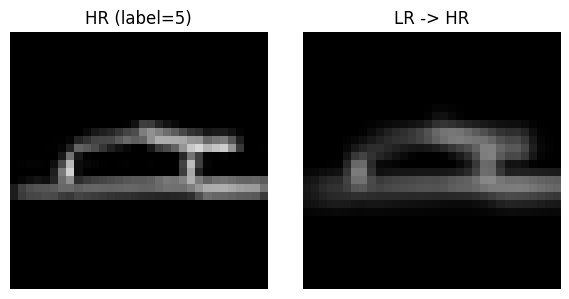

In [ ]:
# ============================================================
# Visual sanity check of HR vs LR->HR reconstruction
# ============================================================
def show_pair(idx):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(x_train_hr[idx])
    plt.title(f"HR (label={y_train[idx]})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(x_train_lr[idx])
    plt.title("LR -> HR")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

show_pair(3034)


In [ ]:
# ============================================================
# Create quadruplets: (pos_hr, pos_lr, neg_hr, neg_lr)
# ============================================================
def create_quadruplets(x_hr, x_lr, labels, num_quadruplets=120_000):
    """
    x_hr, x_lr: (N, 32,32,3)
    labels: (N,)
    Returns four arrays: positive_hr, positive_lr, negative_hr, negative_lr
    """
    num_classes = len(np.unique(labels))
    label_to_indices = {i: np.where(labels == i)[0] for i in range(num_classes)}
    quadruplets = set()

    # Use random with fixed seed (already global seeded)
    while len(quadruplets) < num_quadruplets:
        # Class c for anchor/positive
        c = random.choice(range(num_classes))

        idx_hr = random.choice(label_to_indices[c])   # positive HR
        idx_lr = random.choice(label_to_indices[c])   # positive LR

        # Negative classes (can be same or different; here: both different from c)
        neg_class_hr = random.choice([x for x in range(num_classes) if x != c])
        neg_class_lr = random.choice([x for x in range(num_classes) if x != c])

        idx_nh = random.choice(label_to_indices[neg_class_hr])  # negative HR
        idx_nl = random.choice(label_to_indices[neg_class_lr])  # negative LR

        quadruplet = (idx_hr, idx_lr, idx_nh, idx_nl)

        if quadruplet not in quadruplets:
            quadruplets.add(quadruplet)

    pos_hr, pos_lr, neg_hr, neg_lr = [], [], [], []
    for i_hr, i_lr, i_nh, i_nl in quadruplets:
        pos_hr.append(x_hr[i_hr])
        pos_lr.append(x_lr[i_lr])
        neg_hr.append(x_hr[i_nh])
        neg_lr.append(x_lr[i_nl])

    return (
        np.array(pos_hr, dtype=np.float32),
        np.array(pos_lr, dtype=np.float32),
        np.array(neg_hr, dtype=np.float32),
        np.array(neg_lr, dtype=np.float32),
    )

positive_hr, positive_lr, negative_hr, negative_lr = create_quadruplets(
    x_train_hr, x_train_lr, y_train, num_quadruplets=120_000
)

print("Quadruplet shapes:")
print("positive_hr:", positive_hr.shape)
print("positive_lr:", positive_lr.shape)
print("negative_hr:", negative_hr.shape)
print("negative_lr:", negative_lr.shape)


Quadruplet shapes:
positive_hr: (120000, 32, 32, 3)
positive_lr: (120000, 32, 32, 3)
negative_hr: (120000, 32, 32, 3)
negative_lr: (120000, 32, 32, 3)


In [ ]:
# ============================================================
# Embedding network using MobileNetV2 + L2 normalization
# ============================================================
weight_decay = 1e-4

def build_embedding(input_shape=(32, 32, 3), embedding_dim=128):
    # Pretrained MobileNetV2 backbone
    base = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )

    inp = layers.Input(input_shape)

    # Scale back from [0,1] to [0,255] because preprocess_input expects that range
    x = inp * 255.0
    x = preprocess_input(x)  # MobileNetV2 preprocessing

    x = base(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Dense(
        embedding_dim,
        kernel_regularizer=regularizers.l2(weight_decay)
    )(x)

    # L2-normalize embedding vector
    x = layers.Lambda(lambda t: tf.nn.l2_normalize(t, axis=1))(x)

    return Model(inp, x, name="EmbeddingModel")

embedding_model = build_embedding()
embedding_model.summary()


/tmp/ipython-input-1643224009.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EmbeddingModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,421,952 (9.24 MB)

 Trainable params: 2,387,840 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# ============================================================
# Quadruplet loss with HR and LR margins
# ============================================================
margin_hr_var = tf.Variable(1.0, trainable=False, dtype=tf.float32, name="margin_hr")
margin_lr_var = tf.Variable(1.0, trainable=False, dtype=tf.float32, name="margin_lr")

def quadruplet_loss():
    """
    y_pred is the concatenated embeddings:
    [emb_hr, emb_lr, emb_nh, emb_nl], axis=1
    """
    def loss(y_true, y_pred):
        # Split embeddings along feature dimension
        positive_hr, positive_lr, negative_hr, negative_lr = tf.split(y_pred, 4, axis=1)

        # Squared L2 distances
        pos_dist    = tf.reduce_sum(tf.square(positive_hr - positive_lr), axis=1)
        neg_dist_hr = tf.reduce_sum(tf.square(positive_hr - negative_hr), axis=1)
        neg_dist_lr = tf.reduce_sum(tf.square(positive_lr - negative_lr), axis=1)

        hr_loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist_hr + margin_hr_var, 0.0))
        lr_loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist_lr + margin_lr_var, 0.0))

        return hr_loss + lr_loss

    return loss


# ============================================================
# Quadruplet model wrapper: takes 4 images, outputs 4 embeddings concatenated
# ============================================================
def build_quadruplet_model(embedding):
    inp_hr = layers.Input((32,32,3), name="input_hr")
    inp_lr = layers.Input((32,32,3), name="input_lr")
    inp_nh = layers.Input((32,32,3), name="input_nh")
    inp_nl = layers.Input((32,32,3), name="input_nl")

    emb_hr = embedding(inp_hr)
    emb_lr = embedding(inp_lr)
    emb_nh = embedding(inp_nh)
    emb_nl = embedding(inp_nl)

    out = layers.concatenate([emb_hr, emb_lr, emb_nh, emb_nl], axis=1)
    return Model([inp_hr, inp_lr, inp_nh, inp_nl], out, name="QuadrupletModel")


quad_model = build_quadruplet_model(embedding_model)

quad_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=quadruplet_loss()
)

quad_model.summary()


Model: "QuadrupletModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_hr            │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_lr            │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_nh            │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_nl            │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingModel      │ (None, 128)       │  2,421,952 │ input_hr[0][0],   │
│ (Functional)        │                   │            │ input_lr[0][0],   │
│                     │                   │            │ input_nh[0][0],   │
│                     │                   │            │ input_nl[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ EmbeddingModel[0… │
│ (Concatenate)       │                   │            │ EmbeddingModel[1… │
│                     │                   │            │ EmbeddingModel[2… │
│                     │                   │            │ EmbeddingModel[3… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,421,952 (9.24 MB)

 Trainable params: 2,387,840 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
# ============================================================
# Train/Validation split for quadruplets (manual, since we use tf.data.Dataset)
# ============================================================
N = len(positive_hr)
val_ratio = 0.2
val_size = int(val_ratio * N)

# Deterministic shuffle for reproducibility
rng = np.random.RandomState(SEED)
idx = rng.permutation(N)

train_idx = idx[val_size:]
val_idx   = idx[:val_size]

pos_hr_train = positive_hr[train_idx]
pos_lr_train = positive_lr[train_idx]
neg_hr_train = negative_hr[train_idx]
neg_lr_train = negative_lr[train_idx]

pos_hr_val = positive_hr[val_idx]
pos_lr_val = positive_lr[val_idx]
neg_hr_val = negative_hr[val_idx]
neg_lr_val = negative_lr[val_idx]

print("Train quadruplets:", len(train_idx))
print("Val quadruplets:", len(val_idx))


# ============================================================
# Build tf.data.Dataset for train and val
# ============================================================
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((
    (pos_hr_train, pos_lr_train, neg_hr_train, neg_lr_train),
    np.zeros(len(train_idx), dtype=np.float32)  # dummy y_true
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((
    (pos_hr_val, pos_lr_val, neg_hr_val, neg_lr_val),
    np.zeros(len(val_idx), dtype=np.float32)  # dummy y_true
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Train quadruplets: 96000
Val quadruplets: 24000


In [ ]:
# ============================================================
# Train the quadruplet model
# ============================================================
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

EPOCHS = 100

history = quad_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 282s 149ms/step - loss: 0.9193 - val_loss: 0.4072
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 219s 146ms/step - loss: 0.2705 - val_loss: 0.2785
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 219s 146ms/step - loss: 0.1906 - val_loss: 0.2338
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 219s 146ms/step - loss: 0.1494 - val_loss: 0.1977
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 218s 145ms/step - loss: 0.1229 - val_loss: 0.2070
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 218s 145ms/step - loss: 0.0999 - val_loss: 0.1663
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 219s 146ms/step - loss: 0.0856 - val_loss: 0.1721
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 219s 146ms/step - loss: 0.0724 - val_loss: 0.1581
Epoch 9/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 220s 147ms/step - loss: 0.0626 - val_loss: 0.1603
Epoch 10/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 219s 146ms/step - loss: 0.0519 - val_loss: 0.1658
Epoch 11/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 220s 147ms/step - loss: 0

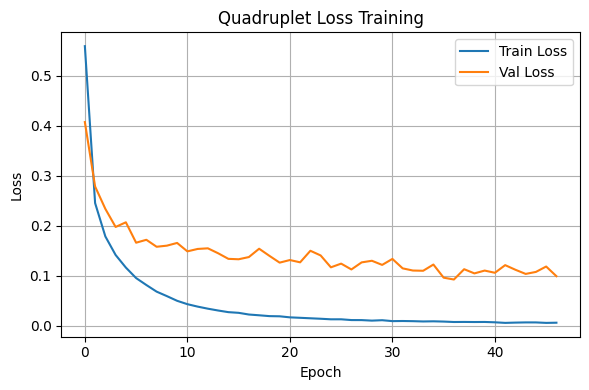

In [ ]:
# ============================================================
# Plot training/validation loss curves
# ============================================================
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Quadruplet Loss Training")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# Combine HR and LR for evaluation (as in your original code)
# ============================================================
x_train_combined = np.concatenate([x_train_hr, x_train_lr], axis=0)
y_train_combined = np.concatenate([y_train, y_train], axis=0)

x_test_combined = np.concatenate([x_test_hr, x_test_lr], axis=0)
y_test_combined = np.concatenate([y_test, y_test], axis=0)

print("Combined train:", x_train_combined.shape, y_train_combined.shape)
print("Combined test:",  x_test_combined.shape, y_test_combined.shape)


# ============================================================
# Extract embeddings using the trained embedding_model
# ============================================================
train_embed = embedding_model.predict(x_train_combined, batch_size=256, verbose=1)
test_embed  = embedding_model.predict(x_test_combined, batch_size=256, verbose=1)

print("Train embeddings:", train_embed.shape)
print("Test embeddings:",  test_embed.shape)


Combined train: (120000, 32, 32, 3) (120000,)
Combined test: (20000, 32, 32, 3) (20000,)
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Train embeddings: (120000, 128)
Test embeddings: (20000, 128)


In [ ]:
# ============================================================
# KNN classifier on learned embeddings
# ============================================================
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embed, y_train_combined)

y_pred = knn.predict(test_embed)

acc = accuracy_score(y_test_combined, y_pred)
f1  = f1_score(y_test_combined, y_pred, average="macro")

print("Accuracy:", acc)
print("Macro F1:", f1)
print("\nClassification report:")
print(classification_report(y_test_combined, y_pred))


Accuracy: 0.89425
Macro F1: 0.893986266304654

Classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2000
           1       0.99      0.97      0.98      2000
           2       0.83      0.85      0.84      2000
           3       0.89      0.90      0.89      2000
           4       0.82      0.82      0.82      2000
           5       0.98      0.98      0.98      2000
           6       0.71      0.68      0.70      2000
           7       0.94      0.97      0.95      2000
           8       0.98      0.99      0.98      2000
           9       0.97      0.94      0.96      2000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



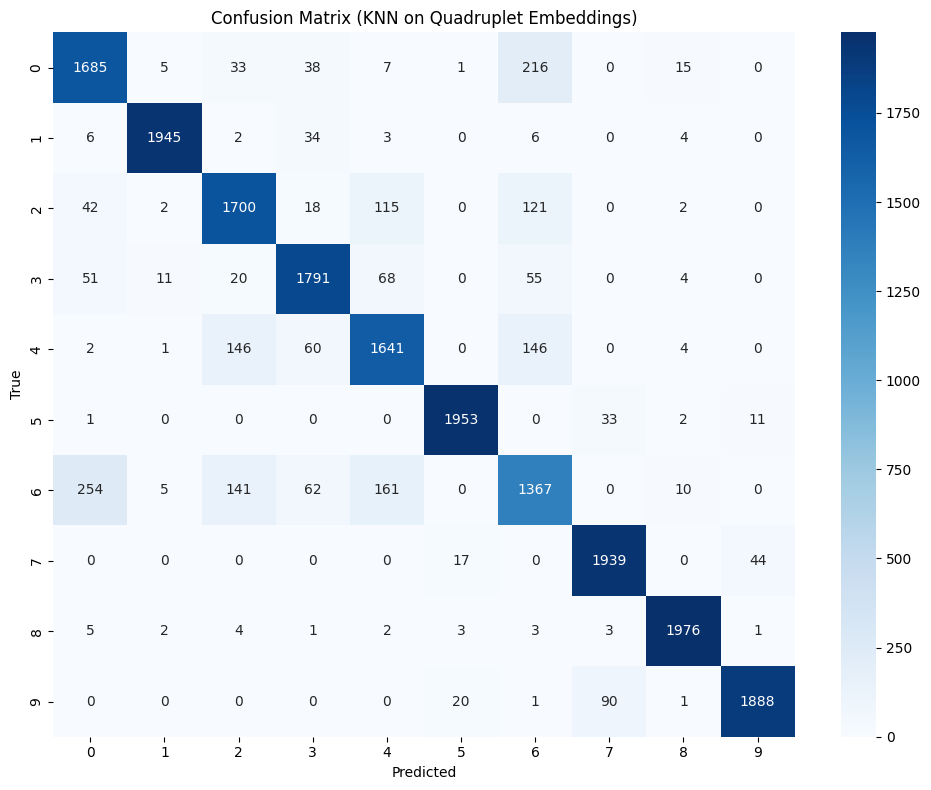

In [ ]:
# ============================================================
# Confusion matrix
# ============================================================
cm = confusion_matrix(y_test_combined, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (KNN on Quadruplet Embeddings)")
plt.tight_layout()
plt.show()


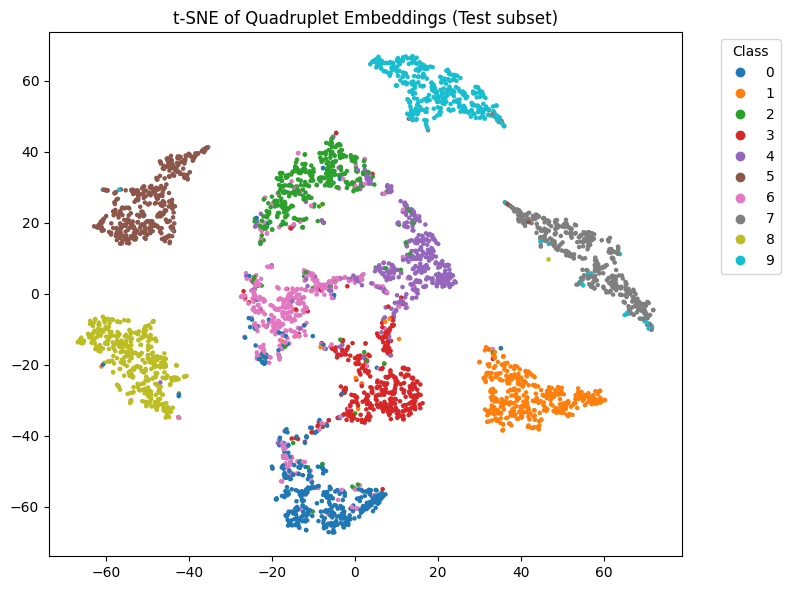

In [ ]:
# ============================================================
# Optional: t-SNE visualization of embeddings
# (Subsample for speed)
# ============================================================
subset = 4000
rng = np.random.RandomState(SEED)
indices = rng.choice(len(test_embed), size=subset, replace=False)

emb_sub = test_embed[indices]
y_sub   = y_test_combined[indices]

tsne = TSNE(n_components=2, random_state=SEED, init="random", learning_rate="auto")
emb_2d = tsne.fit_transform(emb_sub)

plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=y_sub, s=5, cmap='tab10')
plt.legend(*scatter.legend_elements(), title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE of Quadruplet Embeddings (Test subset)")
plt.tight_layout()
plt.show()


Accuracy: 0.89425
F1: 0.893986266304654
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2000
           1       0.99      0.97      0.98      2000
           2       0.83      0.85      0.84      2000
           3       0.89      0.90      0.89      2000
           4       0.82      0.82      0.82      2000
           5       0.98      0.98      0.98      2000
           6       0.71      0.68      0.70      2000
           7       0.94      0.97      0.95      2000
           8       0.98      0.99      0.98      2000
           9       0.97      0.94      0.96      2000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



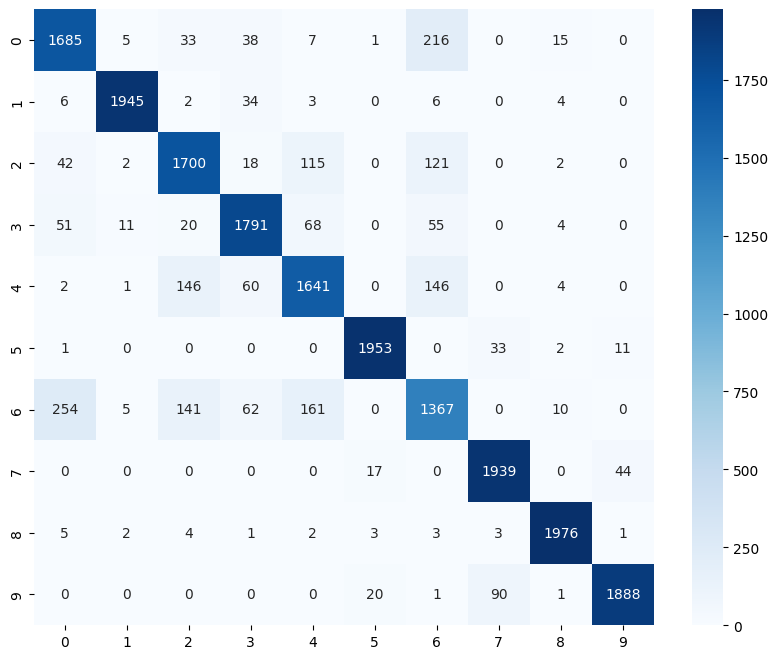

In [ ]:
acc = accuracy_score(y_test_combined, y_pred)
print("Accuracy:", acc)

f1 = f1_score(y_test_combined, y_pred, average="macro")
print("F1:", f1)

print(classification_report(y_test_combined, y_pred))

cm = confusion_matrix(y_test_combined, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


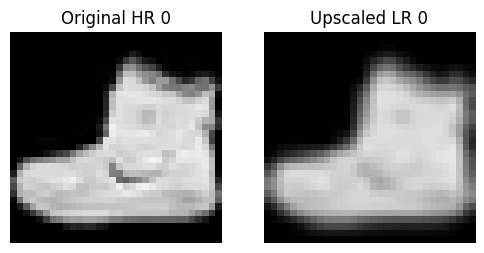

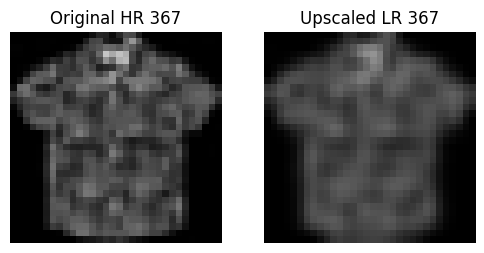

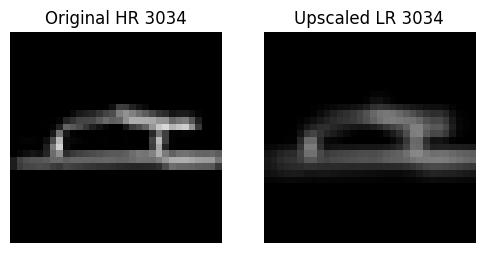

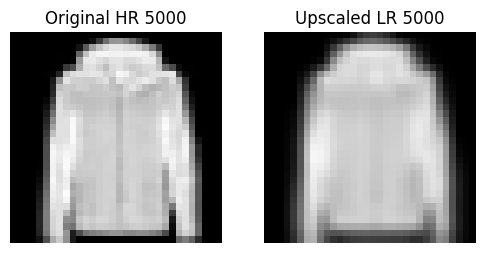

In [ ]:
import matplotlib.pyplot as plt

def show_pair(idx):
    plt.figure(figsize=(6,6))

    # Original HR
    plt.subplot(1,2,1)
    plt.imshow(x_train_hr[idx])
    plt.title(f"Original HR {idx}")
    plt.axis("off")

    # LR→HR Upscaled
    plt.subplot(1,2,2)
    plt.imshow(x_train_lr[idx])
    plt.title(f"Upscaled LR {idx}")
    plt.axis("off")

    plt.show()

# Example indices
show_pair(0)
show_pair(367)
show_pair(3034)
show_pair(5000)
